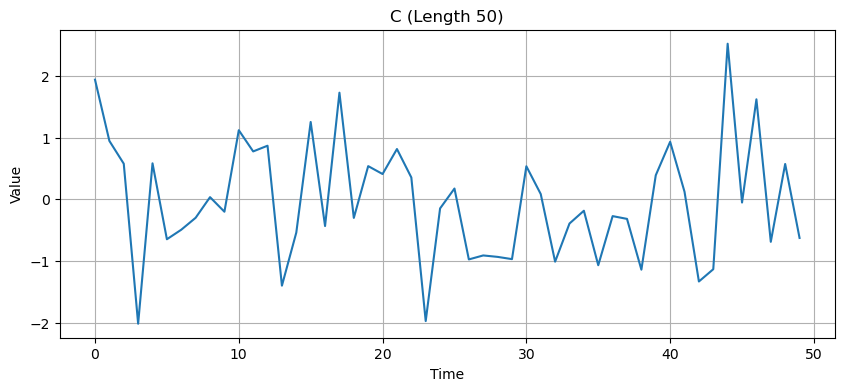

In [8]:
import numpy as np
from numba import njit, prange

import matplotlib.pyplot as plt
from ksfdtw.utils import nearest_neighbor_interpolation
from aeon.distances import euclidean_distance as aeon_euclidean_distance
from ksfdtw.distance_measures import delta

import time

# Generate a random time series with length 100
C = np.random.randn(50)

# Visualize it
plt.figure(figsize=(10, 4))
plt.plot(C)
plt.title("C (Length 50)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

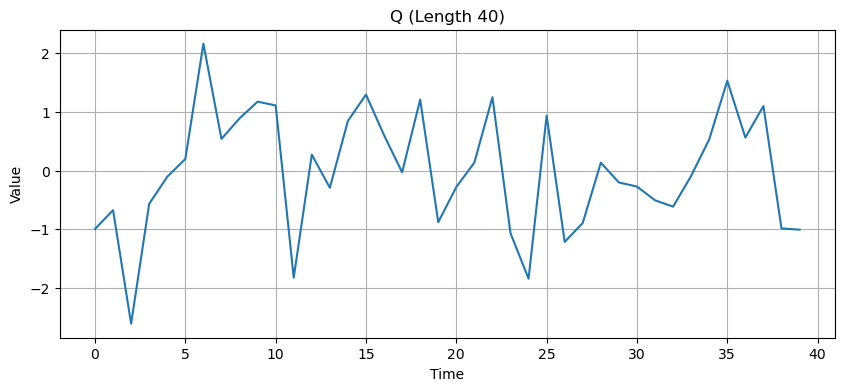

In [3]:
Q = C[:40]

# Visualize it
plt.figure(figsize=(10, 4))
plt.plot(Q)
plt.title("Q (Length 40)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [4]:
C_100 = nearest_neighbor_interpolation(C, 100)

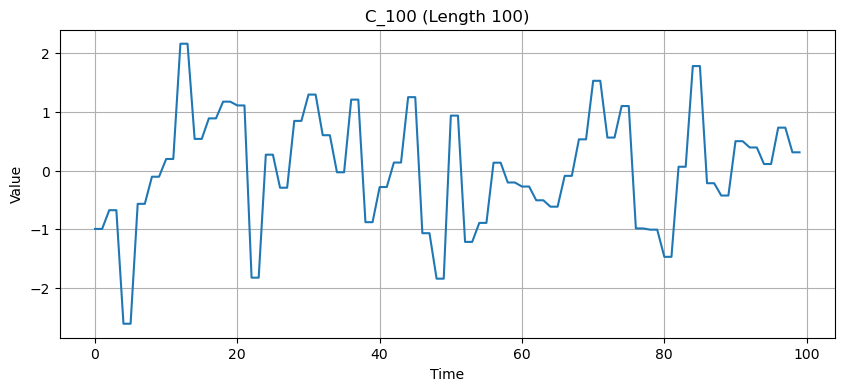

In [5]:
# Visualize it
plt.figure(figsize=(10, 4))
plt.plot(C_100)
plt.title("C_100 (Length 100)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

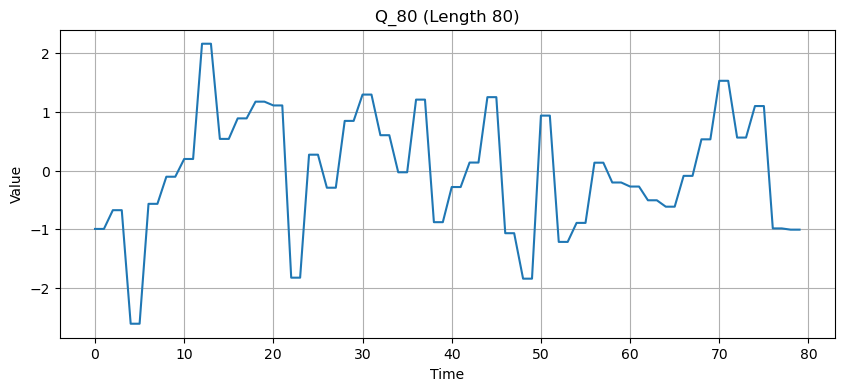

In [6]:
Q_80 = nearest_neighbor_interpolation(Q, 80)

# Visualize it
plt.figure(figsize=(10, 4))
plt.plot(Q_80)
plt.title("Q_80 (Length 80)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [21]:
@njit(parallel=True)
def uniform_scaling_search(Q, C, l):
    m = len(Q)
    n = len(C)

    # Determine the range of prefix lengths
    k_min = int(np.ceil(m / l))
    k_max = min(int(np.ceil(m * l)), n)
    # print(f"Searching k in range [{k_min}, {k_max}]")

    # Determine the target length for rescaling
    L = k_max

    # Rescale the query once to the target length
    Q_rescaled = nearest_neighbor_interpolation(Q, L)

    best_dist = np.inf
    best_k = -1

    # Iterate through all possible prefix lengths in the range
    for k in range(k_min, k_max + 1):
        # Extract the prefix
        C_prefix = C[:k]

        # Rescale the prefix to the target length
        C_prefix_rescaled = nearest_neighbor_interpolation(C_prefix, L)

        # Calculate Euclidean Distance
        # dist = np.linalg.norm(query_rescaled - prefix_rescaled)
        dist = aeon_euclidean_distance(Q_rescaled, C_prefix_rescaled)

        # Update best distance found
        if dist < best_dist:
            best_dist = dist
            best_k = k

    return best_dist, best_k

In [23]:
# Define scaling factor l
l = 3.0

# Run the search
start_time = time.time()
dist, k = uniform_scaling_search(Q, C_100, l)
end_time = time.time()
print(f"Running Time: {end_time - start_time:.4f} seconds")

print(f"Best Euclidean Distance: {dist}")
print(f"Best Prefix Length: {k}")

Running Time: 0.0001 seconds
Best Euclidean Distance: 0.0
Best Prefix Length: 80


In [15]:
@njit(parallel=True)
def uniform_scaling_search_lb(Q, C, l):
    m = len(Q)
    n = len(C)

    # Determine the range of prefix lengths
    k_min = int(np.ceil(m / l))
    k_max = min(int(np.ceil(m * l)), n)
    # print(f"Searching k in range [{k_min}, {k_max}]")

    # Determine the target length for rescaling
    L = k_max

    # Rescale the query once to the target length
    Q_rescaled = nearest_neighbor_interpolation(Q, L)

    best_dist = np.inf
    best_k = -1

    # Define a corresponding indexed collection
    windows_sorted = [np.empty(0, dtype=Q.dtype)]
    windows_sorted.pop()  # Empty the collection
    for j_1 in range(1, k_max + 1):
        idx_start_1 = int(max(1, np.ceil(j_1 / l)))
        idx_end_1 = int(min(np.ceil(j_1 * l), m))
        window = Q[idx_start_1 - 1 : idx_end_1]  # Adjust for zero-based indexing
        windows_sorted.append(np.sort(window))

    lb = 0.0
    for j_1 in range(1, k_min):
        lb += delta(C[j_1 - 1], windows_sorted[j_1 - 1])

    # Iterate through all possible prefix lengths in the range
    for k in range(k_min, k_max + 1):
        lb += delta(C[k-1], windows_sorted[k-1])

        if lb > best_dist:
            # print(f"Pruned at k={k} with lb={lb} > best_dist={best_dist}")
            break

        # Extract the prefix
        C_prefix = C[:k]

        # Rescale the prefix to the target length
        C_prefix_rescaled = nearest_neighbor_interpolation(C_prefix, L)

        # Calculate Euclidean Distance
        # dist = np.linalg.norm(query_rescaled - prefix_rescaled)
        dist = aeon_euclidean_distance(Q_rescaled, C_prefix_rescaled)

        # Update best distance found
        if dist < best_dist:
            best_dist = dist
            best_k = k

    return best_dist, best_k

In [18]:
# Define scaling factor l
l = 3.0

# Run the search
start_time = time.time()
dist, k = uniform_scaling_search_lb(Q, C_100, l)
end_time = time.time()
print(f"Running Time: {end_time - start_time:.4f} seconds")

print(f"Best Euclidean Distance: {dist}")
print(f"Best Prefix Length: {k}")

Running Time: 0.0002 seconds
Best Euclidean Distance: 0.0
Best Prefix Length: 80


In [14]:
# # 1. Define a particular query Q (e.g., length 50)
# Q_test = np.random.randn(50)

# 2. Generate 100 C's, each with length 100
num_candidates = 99
len_candidate = 100
Cs = [np.random.randn(len_candidate) for _ in range(num_candidates)]
print(f"Total candidates before adding C_100: {len(Cs)}")
Cs.append(C_100)
print(f"Total candidates including C_100: {len(Cs)}")

Total candidates before adding C_100: 99
Total candidates including C_100: 100


In [27]:

# print(f"Testing query of length {len(Q_test)} against {len(Cs_test)} candidates of length {len_candidate} with l={l_test}...")

# 4. Run the search
start_time = time.time()
results = []

for i, C in enumerate(Cs):
    dist, k = uniform_scaling_search(Q, C, l)
    results.append((i, dist, k))

end_time = time.time()

print(f"Total execution time: {end_time - start_time:.4f} seconds")
print(f"Average time per search: {(end_time - start_time) / num_candidates:.4f} seconds")

# 5. Display sample results
print("\nSample results (first 5):")
print(f"{'Index':<10} {'Best Dist':<15} {'Best k':<10}")
for res in results:
    print(f"{res[0]:<10} {res[1]:<15.4f} {res[2]:<10}")


Total execution time: 0.0031 seconds
Average time per search: 0.0000 seconds

Sample results (first 5):
Index      Best Dist       Best k    
0          11.0218         28        
1          9.5421          14        
2          10.9209         90        
3          11.7676         19        
4          13.4343         60        
5          11.1875         85        
6          13.3069         94        
7          12.0060         71        
8          9.8919          24        
9          11.3388         42        
10         11.5354         44        
11         11.5712         35        
12         11.7079         77        
13         11.5386         32        
14         10.6154         15        
15         11.3020         14        
16         10.3151         19        
17         11.7337         72        
18         11.6294         44        
19         9.8941          22        
20         11.4549         64        
21         10.1402         23        
22         10.9729    

In [29]:

# print(f"Testing query of length {len(Q_test)} against {len(Cs_test)} candidates of length {len_candidate} with l={l_test}...")
# 4. Run the search
start_time = time.time()
results = []

for i, C in enumerate(Cs):
    dist, k = uniform_scaling_search_lb(Q, C, l)
    results.append((i, dist, k))

end_time = time.time()

print(f"Total execution time: {end_time - start_time:.4f} seconds")
print(f"Average time per search: {(end_time - start_time) / num_candidates:.4f} seconds")

# 5. Display sample results
print("\nSample results (first 5):")
print(f"{'Index':<10} {'Best Dist':<15} {'Best k':<10}")
for res in results:
    print(f"{res[0]:<10} {res[1]:<15.4f} {res[2]:<10}")


Total execution time: 0.0193 seconds
Average time per search: 0.0002 seconds

Sample results (first 5):
Index      Best Dist       Best k    
0          11.0218         28        
1          9.5421          14        
2          10.9209         90        
3          11.7676         19        
4          13.4343         60        
5          11.1875         85        
6          13.3069         94        
7          12.0060         71        
8          9.8919          24        
9          11.3388         42        
10         11.5354         44        
11         11.5712         35        
12         11.7079         77        
13         11.5386         32        
14         10.6154         15        
15         11.3020         14        
16         10.3151         19        
17         11.7337         72        
18         11.6294         44        
19         9.8941          22        
20         11.4549         64        
21         10.1402         23        
22         10.9729    

In [13]:
uniform_scaling_search(Q, Cs[-1], l)

(0.0, 80)